## Задание 1. Написать теггер на данных с русским языком
1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбинации
2. написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов
3. сравнить все реализованные методы, сделать выводы


In [30]:
from nltk.tag import DefaultTagger, UnigramTagger, BigramTagger, TrigramTagger

In [11]:
!wget -O ./data/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
!wget -O ./data/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

--2022-08-19 13:13:31--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-08-19 13:13:32 ERROR 404: Not Found.

--2022-08-19 13:13:32--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14704579 (14M) [text/plain]
Saving to: ‘./data/ru_syntagrus-ud-dev.conllu’

./data/ru_syntagrus 100%[===================>]  

In [22]:
import pyconll
from nltk import word_tokenize

In [15]:
tag_data = pyconll.load_from_file('data/ru_syntagrus-ud-dev.conllu')

In [16]:
fdata = []
for sent in tag_data[:]:
    fdata.append([(token.form, token.upos) for token in sent])

In [32]:
SENT = 'Съешь еще этих мягких французских булочек, да выпей же чаю'

In [40]:
default_tagger = DefaultTagger('VERB')
unigram_tagger = UnigramTagger(fdata, backoff=default_tagger)
unigram_tagger.tag(word_tokenize(SENT))

[('Съешь', 'VERB'),
 ('еще', 'ADV'),
 ('этих', 'DET'),
 ('мягких', 'ADJ'),
 ('французских', 'ADJ'),
 ('булочек', 'VERB'),
 (',', 'PUNCT'),
 ('да', 'CCONJ'),
 ('выпей', 'VERB'),
 ('же', 'PART'),
 ('чаю', 'NOUN')]

In [42]:
bigram_tagger = BigramTagger(fdata, backoff=None)
bigram_tagger.tag(word_tokenize(SENT))

[('Съешь', None),
 ('еще', 'ADV'),
 ('этих', None),
 ('мягких', None),
 ('французских', None),
 ('булочек', None),
 (',', 'PUNCT'),
 ('да', 'CCONJ'),
 ('выпей', None),
 ('же', None),
 ('чаю', None)]

In [53]:
trigram_tagger = TrigramTagger(fdata, backoff=None)
trigram_tagger.tag(word_tokenize(SENT))

[('Съешь', None),
 ('еще', None),
 ('этих', None),
 ('мягких', None),
 ('французских', None),
 ('булочек', None),
 (',', None),
 ('да', None),
 ('выпей', None),
 ('же', None),
 ('чаю', None)]

In [44]:
bigram_tagger = BigramTagger(fdata, backoff=unigram_tagger)
trigram_tagger = TrigramTagger(fdata, backoff=bigram_tagger)
trigram_tagger.tag(word_tokenize(SENT))

[('Съешь', 'VERB'),
 ('еще', 'ADV'),
 ('этих', 'DET'),
 ('мягких', 'ADJ'),
 ('французских', 'ADJ'),
 ('булочек', 'VERB'),
 (',', 'PUNCT'),
 ('да', 'CCONJ'),
 ('выпей', 'VERB'),
 ('же', 'PART'),
 ('чаю', 'NOUN')]

### Свой POS теггер

In [39]:
fdata[0][:15]

[('Алгоритм', 'NOUN'),
 (',', 'PUNCT'),
 ('от', 'ADP'),
 ('имени', 'NOUN'),
 ('учёного', 'NOUN'),
 ('аль', 'PART'),
 ('-', 'PUNCT'),
 ('Хорезми', 'PROPN'),
 (',', 'PUNCT'),
 ('-', 'PUNCT'),
 ('точный', 'ADJ'),
 ('набор', 'NOUN'),
 ('инструкций', 'NOUN'),
 (',', 'PUNCT'),
 ('описывающих', 'VERB')]

In [54]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [59]:
class MyTagger:
    def preprocess_word(self, word):
        return morph.parse(word.lower())[0].normal_form


    def _make_dict(self, data):
        d = {}
        for i in range(len(data)):
            sent = data[i]
            for j in range(len(sent)):
                pair = sent[j]
                word = pair[0]
                pos = pair[1]
                if word != None:
                    lemma = self.preprocess_word(word)
                    d[lemma] = pos
        return d


    def __init__(self, data, default='VERB'):
        self.dictionary = self._make_dict(data)
        self.default = default
    

    def tag(self, tokens):
        tags = []
        for word in tokens:
            pos = self.default
            lemma = self.preprocess_word(word)
            if lemma in self.dictionary:
                pos = self.dictionary[lemma]
            tags.append((word, pos))
        return tags

In [60]:
mtag = MyTagger(fdata)
mtag.tag(word_tokenize(SENT))

[('Съешь', 'VERB'),
 ('еще', 'PART'),
 ('этих', 'DET'),
 ('мягких', 'ADJ'),
 ('французских', 'ADJ'),
 ('булочек', 'VERB'),
 (',', 'PUNCT'),
 ('да', 'PART'),
 ('выпей', 'VERB'),
 ('же', 'PART'),
 ('чаю', 'NOUN')]

#### Вывод

UnigramTagger + DefaultTagger и мой теггер хороши. BigramTagger и TrigramTagger хороши только вместе с UnigramTagger

## Задание 2. Проверить, насколько хорошо работает NER

Данные брать из http://www.labinform.ru/pub/named_entities/

1. проверить NER из nltk/spacy/deeppavlov.

2. написать свой NER, попробовать разные подходы.
   
   передаём в сетку токен и его соседей.
   
   передаём в сетку только токен.
   
   свой вариант.

3. сравнить свои реализованные подходы на качество — вывести precision/recall/f1_score.


In [77]:
import pandas as pd
import numpy as np
import nltk

In [73]:
def read_ner_text(filename):
    with open('data/Collection5/' + filename) as f:
        text = f.read()
    return word_tokenize(text)

In [75]:
text1 = read_ner_text('001.txt')
text1[:15]

['Россия',
 'рассчитывает',
 'на',
 'конструктивное',
 'воздействие',
 'США',
 'на',
 'Грузию',
 '04/08/2008',
 '12:08',
 'МОСКВА',
 ',',
 '4',
 'авг',
 '-']

In [86]:
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/blaze/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/blaze/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/blaze/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

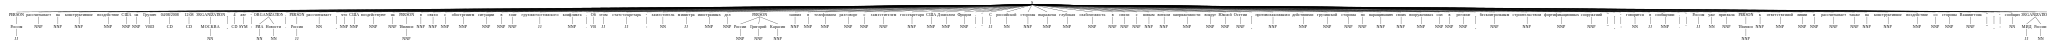

In [88]:
nltk.ne_chunk(nltk.pos_tag(text1))

### Своя NER

In [99]:
from corus import load_ne5

records = load_ne5('data/Collection5/')
next(records)

Ne5Markup(
    id='1047',
    text='Жириновский предлагает обменять с США Сноудена на Бута\r\n\r\nЛидер ЛДПР Владимир Жириновский предложил обменять бывшего сотрудника ЦРУ США Эдварда Сноудена, который прибыл в Москву, на осужденного в Америке бизнесмена Виктора Бута.\r\n\r\n"Сноудена ни в коем случае не высылать в США, а обменять на Виктора Бута и Константина Ярошенко. В идеале — добавить генерала Олега Калугина", — написал он в своем микроблоге в Twitter.\r\n\r\nСноуден, работавший на компанию Booz Allen Hamilton — подрядчика Центрального разведывательного управления США, в начале июня распространил секретный ордер суда, по которому спецслужбы получили доступ ко всем звонкам крупнейшего сотового оператора Verizon, а также данные о сверхсекретной программе агентства национальной безопасности PRISM, позволяющей отслеживать электронные коммуникации на крупнейших сайтах. В воскресенье стало известно, что Сноуден прибыл из Гонконга в Москву и запросил убежища в Эквадоре.\r\n\r\nЧто ждет Э

In [100]:
from razdel import tokenize

words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [102]:
words_docs[:15]

[['Д', 'PER'],
 ['.', 'PER'],
 ['Медведев', 'PER'],
 ['назначил', 'OUT'],
 ['ряд', 'OUT'],
 ['глав', 'OUT'],
 ['региональных', 'OUT'],
 ['МВД', 'ORG'],
 ['Президент', 'OUT'],
 ['России', 'GEOPOLIT'],
 ['Дмитрий', 'PER'],
 ['Медведев', 'PER'],
 ['сегодня', 'OUT'],
 ['своим', 'OUT'],
 ['указом', 'OUT']]

In [104]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn import model_selection, preprocessing, linear_model

In [106]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])
df_words.head()

,word,tag
0,Д,PER
1,.,PER
2,Медведев,PER
3,назначил,OUT
4,ряд,OUT


In [154]:
def make_neighbors():
    left_neighbor = []
    right_neighbor = []
    size = df_words.index.stop
    end = size - 1
    for i in range(size):
        ln_ix = max(i - 1, 0)
        rn_ix = min(i + 1, end)
        left_neighbor.append(df_words.iloc[ln_ix]['word'])
        right_neighbor.append(df_words.iloc[rn_ix]['word'])
    return (left_neighbor, right_neighbor)

In [155]:
left_nb, right_nb = make_neighbors()

In [156]:
df_words['prev_word'] = left_nb
df_words['next_word'] = right_nb

In [157]:
df_words.head(3)

,word,tag,prev_word,next_word
0,Д,PER,Д,.
1,.,PER,Д,Медведев
2,Медведев,PER,.,назначил


In [158]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words.drop('tag', axis=1), df_words['tag'])
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [199]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
train_data = train_data.batch(128)
valid_data = valid_data.batch(128)

In [200]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [201]:
def custom_standardization(input_data):
    return input_data

vocab_size = 15000
seq_len = 10
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 3),
    output_sequence_length=seq_len)
text_data = train_data.map(lambda x, y: x[0])
vectorize_layer.adapt(text_data)

len(vectorize_layer.get_vocabulary())

2022-08-22 19:24:55.548442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2340

In [202]:
next(iter(train_data))[0][:, 1]

<tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'.',
       b'\xd0\xbb\xd0\xb8\xd0\xbd\xd0\xb5\xd0\xb9\xd0\xbd\xd0\xbe\xd0\xb3\xd0\xbe',
       b'5',
       b'\xd0\xbf\xd1\x80\xd0\xb5\xd1\x81\xd1\x81-\xd1\x81\xd0\xbb\xd1\x83\xd0\xb6\xd0\xb1\xd1\x8b',
       b'\xd0\xb2', b',', b'.', b'"',
       b'\xd0\xba\xd0\xb0\xd1\x87\xd0\xb5\xd1\x81\xd1\x82\xd0\xb2\xd0\xb5',
       b'\xd0\xbd\xd0\xb0', b'"',
       b'\xd0\xb0\xd1\x80\xd0\xbc\xd0\xb8\xd0\xb5\xd0\xb9',
       b'\xd0\xb3\xd0\xb4\xd0\xb5',
       b'\xd0\xbf\xd1\x80\xd0\xb5\xd0\xb4\xd1\x81\xd1\x82\xd0\xb0\xd0\xb2\xd0\xbb\xd0\xb5\xd0\xbd\xd0\xbd\xd1\x8b\xd0\xb5',
       b'\xd0\xad\xd0\xba\xd0\xb2\xd0\xb0\xd0\xb4\xd0\xbe\xd1\x80\xd0\xb0',
       b'\xd0\xb2\xd0\xb8\xd0\xb7\xd0\xb8\xd1\x82',
       b'\xd0\xbc\xd0\xb8\xd0\xbd\xd0\xb8\xd1\x81\xd1\x82\xd1\x80\xd0\xbe\xd0\xbc',
       b'\xd0\xbf\xd0\xbe\xd0\xb2\xd0\xbb\xd0\xb8\xd1\x8f\xd1\x82\xd1\x8c',
       b'4', b'\xd0\xbd\xd0\xb0\xd1\x81',
       b'\xd1\x87\xd0\xbb\xd0\xb5\xd0\xbd',


In [203]:
embedding_dim = 64

class ModelNER(tf.keras.Model):
    def __init__(self):
        super(ModelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        xs = []
        for i in range(3):
            z = vectorize_layer(x[:, i])
            z = self.emb(z)
            pool_z = self.gPool(z)
            xs.append((pool_z))
        pool_x = tf.concat(xs, axis=1)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [204]:
ner_model = ModelNER()
ner_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
ner_model.fit(train_data, validation_data=valid_data, epochs=3)

Epoch 1/3


2022-08-22 19:24:59.056108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1555/1555 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8835

2022-08-22 19:25:30.633713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1555/1555 [==============================] - 35s 22ms/step - loss: 0.3831 - accuracy: 0.8835 - val_loss: 0.3141 - val_accuracy: 0.9007
Epoch 2/3
1555/1555 [==============================] - 36s 23ms/step - loss: 0.2850 - accuracy: 0.9076 - val_loss: 0.3051 - val_accuracy: 0.9039
Epoch 3/3
1555/1555 [==============================] - 32s 21ms/step - loss: 0.2722 - accuracy: 0.9107 - val_loss: 0.2966 - val_accuracy: 0.9050


Мой метод заключался в передачи соседних токенов в сетку, а также токенизации с n-грамами

In [206]:
y_pred = ner_model.predict(valid_x)

2073/2073 [==============================] - 10s 5ms/step


In [208]:
from sklearn.metrics import classification_report

In [215]:
classification_report(valid_y, np.argmax(y_pred, axis=1)).split('\n')

['              precision    recall  f1-score   support',
 '',
 '           0       0.93      0.59      0.72      1131',
 '           1       0.92      0.50      0.65      1177',
 '           2       0.89      0.60      0.72       604',
 '           3       0.77      0.44      0.56      3534',
 '           4       0.91      0.99      0.95     54616',
 '           5       0.94      0.52      0.67      5245',
 '',
 '    accuracy                           0.91     66307',
 '   macro avg       0.89      0.61      0.71     66307',
 'weighted avg       0.90      0.91      0.89     66307',
 '']